### Initialize the environment

In [21]:
import theano
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
src_dir='../src' # source directory
run_dir='../MDBN_run' # directory with the results of previous runs
data_dir='../data' # directory with the data files

In [23]:
import sys
sys.path.insert(0, src_dir)
import MDBN
import AMLsm2

### Load the experiment results

In [25]:
date_time='2017-01-14_2113' # specify the date and time of the run in the format YYYY-MM-DD_HHMM
run='7'
runfile='AML_Batch_'+date_time+'/Exp_'+date_time+'_run_'+run+'.npz' # location of the experiment results
config, dbn_dict = MDBN.load_network(runfile, run_dir)

Adding a layer with 559 input and 40 outputs
Adding a layer with 19937 input and 400 outputs
Adding a layer with 400 input and 40 outputs
Adding a layer with 1686 input and 200 outputs
Adding a layer with 200 input and 20 outputs
Adding a layer with 100 input and 24 outputs
Adding a layer with 24 input and 3 outputs


In [26]:
config

{u'GE': {u'batchSize': 10,
  u'datafile': u'AML/AML_gene_expression_table2.csv',
  u'epochs': [240, 240],
  'inputNodes': 19937,
  u'k': 10,
  u'lambdas': [0.01, 0.1],
  u'layersNodes': [400, 40],
  u'lr': [0.001, 0.01],
  u'persistent': True},
 u'ME': {u'batchSize': 10,
  u'datafile': u'AML/AML_miRNA_Seq_table2.csv',
  u'epochs': [240],
  'inputNodes': 559,
  u'k': 10,
  u'lambdas': [0.01, 0.01],
  u'layersNodes': [40],
  u'lr': [0.001],
  u'persistent': True},
 u'SM': {u'batchSize': 10,
  u'datafile': u'AML/AML_somatic_mutations_table2.csv',
  u'epochs': [240, 240],
  'inputNodes': 1686,
  u'k': 10,
  u'lambdas': [0.01, 0.1],
  u'layersNodes': [200, 20],
  u'lr': [0.001, 0.01],
  u'persistent': True},
 u'pathways': [u'ME', u'GE', u'SM'],
 u'runs': 10,
 u'seed': 1234,
 u'top': {u'batchSize': 1,
  u'epochs': [160, 160],
  'inputNodes': 100,
  u'k': 10,
  u'layersNodes': [24, 3],
  u'lr': [0.01, 0.01],
  u'persistent': True}}

### Visualize the results graphically

In [27]:
datafiles = AMLsm2.prepare_AML_TCGA_datafiles(config)

In [28]:
dbn_output_list=[]
for key in config['pathways']:
    dbn_output, _ = dbn_dict[key].MLP_output_from_datafile(datafiles[key], datadir=data_dir)
    dbn_output_list.append(dbn_output)

(-0.5, 99.5, 169.5, -0.5)

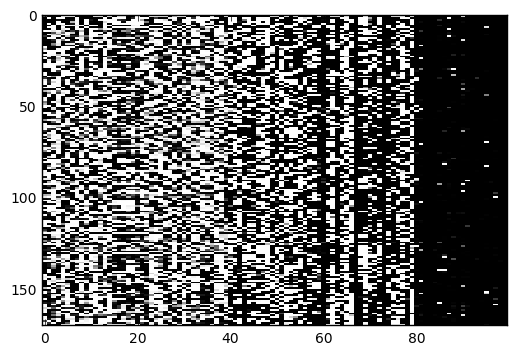

In [29]:
joint_layer = np.concatenate(dbn_output_list,axis=1)
plt.imshow(joint_layer, cmap='gray',interpolation='none')
plt.axis('tight')

([<matplotlib.axis.XTick at 0x124aa5dd0>,
 <a list of 3 Text xticklabel objects>)

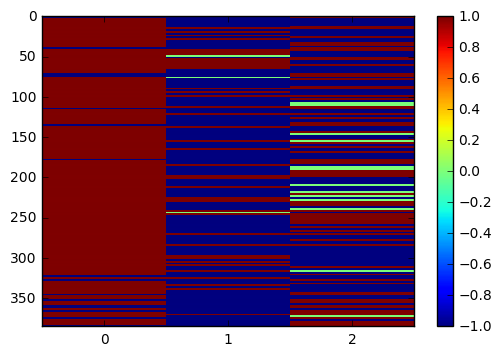

In [30]:
top_output = dbn_dict['top'].get_output(theano.shared(joint_layer,borrow=True))
plt.imshow((top_output>0.8)*np.ones_like(top_output)-(top_output<0.2)*np.ones_like(top_output),interpolation='none',extent=[0,3,385,0])
plt.colorbar()
plt.axis('tight')
plt.xticks(np.arange(0.5,3.5,1),('0','1','2'))

([<matplotlib.axis.XTick at 0x122d33950>,
 <a list of 3 Text xticklabel objects>)

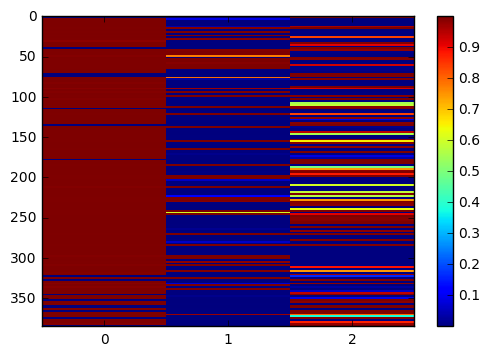

In [31]:
plt.imshow(top_output, interpolation='none',extent=[0,3,385,0])
plt.axis('tight')
plt.colorbar()
plt.xticks(np.arange(0.5,3.5,1),('0','1','2'))

([array([  16.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  154.]),
  array([ 125.,    1.,    0.,    0.,    0.,    0.,    1.,    2.,    0.,   41.]),
  array([ 87.,   1.,   0.,   1.,   0.,   6.,   3.,   3.,   6.,  63.])],
 array([  4.94430896e-09,   9.99999329e-02,   1.99999861e-01,
          2.99999789e-01,   3.99999717e-01,   4.99999645e-01,
          5.99999573e-01,   6.99999501e-01,   7.99999429e-01,
          8.99999357e-01,   9.99999285e-01]),
 <a list of 3 Lists of Patches objects>)

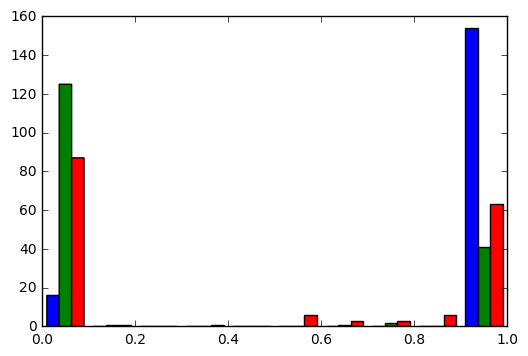

In [32]:
plt.hist(top_output)

In [33]:
code = (top_output[:,0:3] > 0.5) * np.ones_like(top_output[:,0:3])

In [34]:
from utils import find_unique_classes
U = find_unique_classes(code)
cl = U[0]

(array([  1.,  15.,  62.,  48.,  26.,  18.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <a list of 6 Patch objects>)

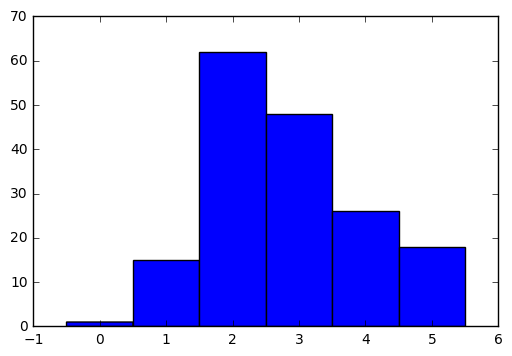

In [35]:
max_cl = np.max(cl)
plt.hist(cl,bins=np.arange(-0.5,max_cl + 1.5,1))

Check Survival curves for the different classes
===============================================

In [36]:
import csv
id=[]
with open('../data/'+datafiles['ME']) as f:
    my_csv = csv.reader(f,delimiter='\t')
    id = my_csv.next()

In [37]:
stat={}
with open('../data/AML/AML_clinical_data2.csv') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        patient_id=row[0]
        stat[patient_id]=(row[4],row[7],row[6])

In [38]:
import re
time_list = []
event_list = []
group_list = []
print('The following case IDs were  not found in clinical data')
for index, key in enumerate(id[1:]):
    m = re.match('TCGA-\w+-\d+', key)
    patient_id = m.group(0)
    if patient_id in stat:
        patient_stat = stat[patient_id]
        add_group = True
        try:
            time_list.append(float(patient_stat[2]))
            event_list.append(1)
        except ValueError:
            try:
                time_list.append(float(patient_stat[1]))
                event_list.append(0)
            except ValueError:
                print('No data for %s' % patient_id)
                add_group = False
        if add_group:
            group_list.append(cl[index])
    else:
        print(patient_id)

The following case IDs were  not found in clinical data
No data for TCGA-AB-2887
No data for TCGA-AB-2891
No data for TCGA-AB-2918
No data for TCGA-AB-2921
No data for TCGA-AB-2930
No data for TCGA-AB-2940
No data for TCGA-AB-2943
No data for TCGA-AB-2946
No data for TCGA-AB-2975


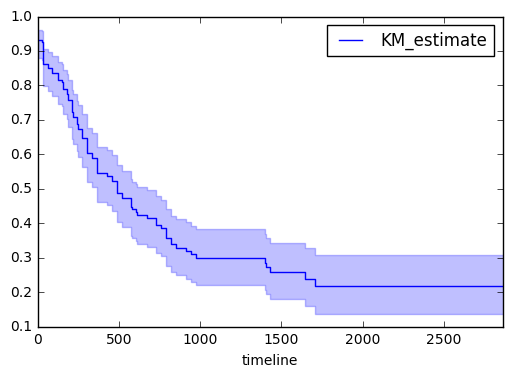

In [39]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(time_list,event_observed=event_list)
kmf.plot()

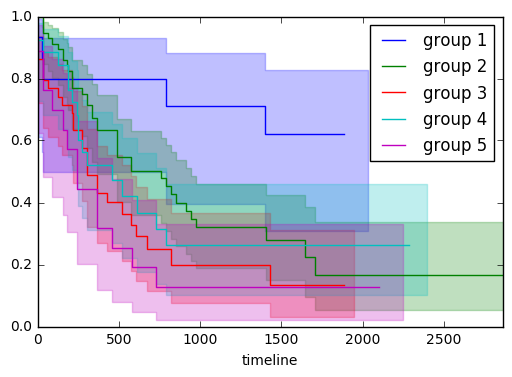

In [41]:
T=np.array(time_list)
E=np.array(event_list)
ix = (np.array(group_list) == 1)
kmf.fit(T[ix], E[ix], label='group 1')
ax=kmf.plot()
for i in range(2,6):
    ix=(np.array(group_list)==i)
    kmf.fit(T[ix], E[ix], label='group %d' % i)
    kmf.plot(ax=ax)